<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/AprendizadoMaquina/T%C3%B3pico%2004%20-%20Deep%20Learning/exercicio_simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Simpsons classification

In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

In [ ]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):

      x = x.numpy()
      x = np.squeeze(x)
      y = y.numpy()
      plot_sidebsyide(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
!wget https://github.com/andrehochuli/teaching/raw/main/datasets/Simpsons.zip -O Simpsons.zip

--2024-10-22 23:19:00--  https://github.com/andrehochuli/teaching/raw/main/datasets/Simpsons.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrehochuli/teaching/main/datasets/Simpsons.zip [following]
--2024-10-22 23:19:00--  https://raw.githubusercontent.com/andrehochuli/teaching/main/datasets/Simpsons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14750621 (14M) [application/zip]
Saving to: ‘Simpsons.zip’

Simpsons.zip        100%[===================>]  14.07M  --.-KB/s    in 0.1s    

2024-10-22 23:19:01 (114 MB/s) - ‘Simpsons.zip’ saved [14750621/14750621]



In [ ]:
!unzip -qo Simpsons.zip

In [ ]:
data_dir = './Simpsons/Treino'
batch_size_ = 32
input_shape_ = (96,96,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 253 files belonging to 6 classes.
Using 203 files for training.
Found 253 files belonging to 6 classes.
Using 50 files for validation.


['bart', 'family', 'homer', 'lisa', 'maggie', 'marge']
tf.Tensor([0 5 1 0 4 0 2 0 2 0 2 2 0 0 2 2 0 3 5 3 0 0 2 2 2 1 3 3 4 5 3 0], shape=(32,), dtype=int32)


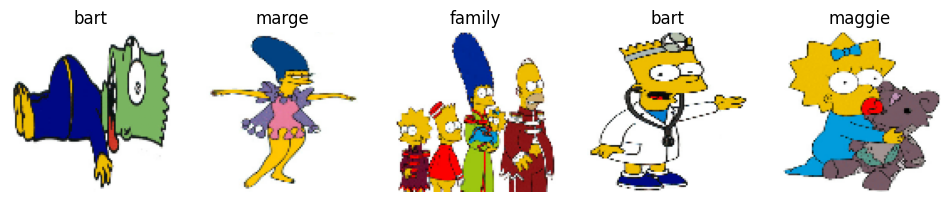

tf.Tensor([0 4 4 5 0 3 2 1 1 2 0 3 2 4 0 3 5 0 0 2 5 0 2 2 2 5 0 1 3 0 1 1], shape=(32,), dtype=int32)


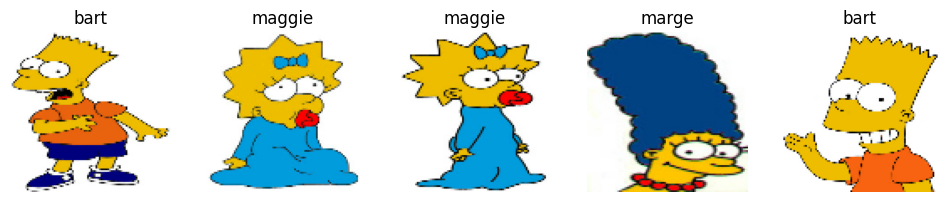

tf.Tensor([2 0 3 0 0 0 4 0 2 5 0 1 0 2 3 2 0 0 4 5 5 4 4 0 1 2 3 0 4 0 5 4], shape=(32,), dtype=int32)


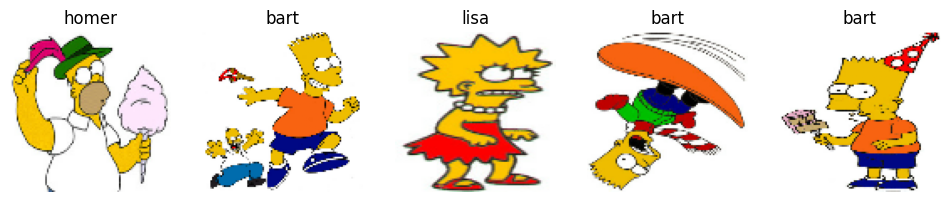

tf.Tensor([2 4 0 1 0 3 3 2 2 5 0 2 2 2 0 0 0 3 5 1 0 3 1 4 2 1 3 3 4 4 2 1], shape=(32,), dtype=int32)


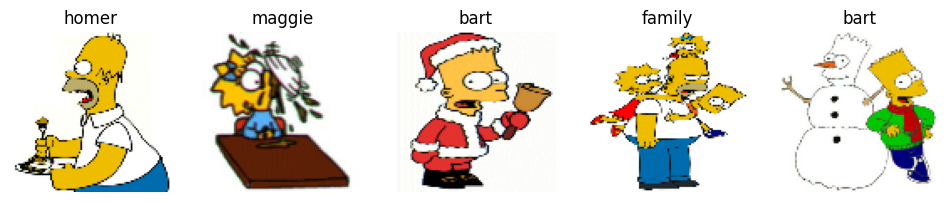

tf.Tensor([0 4 4 4 0 2 5 4 4 2 3 5 1 4 2 3 3 0 0 0 2 1 2 0 0 2 0 2 0 5 0 3], shape=(32,), dtype=int32)


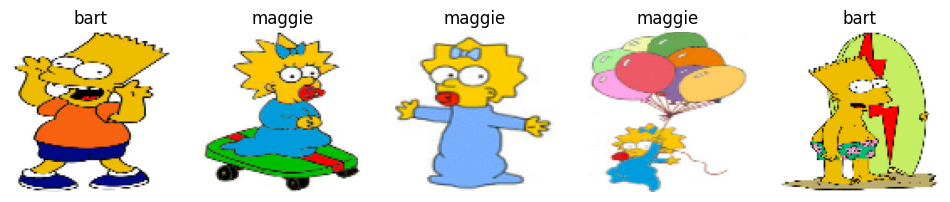

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):

  titles = []
  print(lbl)
  for i in lbl:
    titles.append(class_names[i])

  plot_sidebyside(img[:5]/255.,titles[:5])

In [ ]:
y_train = []
x_train = []
#test_ds = test_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

for img, labels in train_ds:
    y_train.extend(labels.numpy())
    x_train.extend(img)

y_train = np.array(y_train)
x_train = np.array(x_train)

In [ ]:
ret = np.unique(y_train,return_counts=True)
print(class_names)
print(ret)

['bart' 'family' 'homer' 'lisa' 'maggie' 'marge']
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([61, 22, 46, 30, 25, 19]))


In [ ]:
model = models.Sequential()

#Feature Learning (Convolutions)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
######################################

# Fully-Connect (Classifcation)
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))



model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,838 (1.03 MB)

 Trainable params: 268,838 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_ = 50
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - acc: 0.4076 - loss: 1.5130 - val_acc: 0.3600 - val_loss: 1.6202
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.3861 - loss: 1.5381 - val_acc: 0.4600 - val_loss: 1.3647
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.4596 - loss: 1.2902 - val_acc: 0.4800 - val_loss: 1.2278
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 0.6493 - loss: 0.9835 - val_acc: 0.5200 - val_loss: 1.1812
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.6201 - loss: 0.9415 - val_acc: 0.6000 - val_loss: 1.1005
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.6702 - loss: 0.8826 - val_acc: 0.6800 - val_loss: 1.1131
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.7153 - loss: 0.7488 - val_acc: 0.6200 - val_loss: 1.1333
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.6582 - loss: 0.8023 - val_acc: 0.6400 - val_loss: 1.1511
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.7260 - loss: 0.7503 -

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


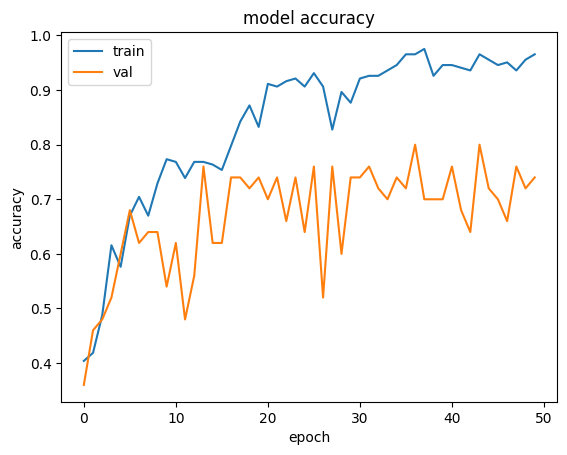

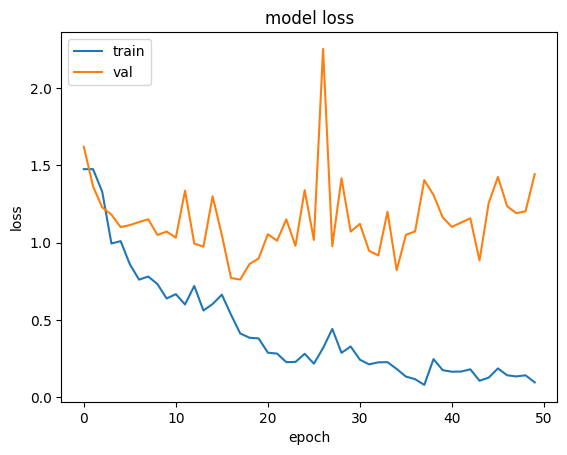

In [ ]:
plot_history(history)

In [ ]:
model = models.Sequential()

#Feature Learning (Convolutions)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

######################################

# Fully-Connect (Classifcation)
model.add(layers.Dropout(0.10))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 20, 20, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,982 (3.40 MB)

 Trainable params: 890,982 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_ = 30
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 882ms/step - acc: 0.2256 - loss: 55.9487 - val_acc: 0.2600 - val_loss: 1.9323
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.1934 - loss: 1.8111 - val_acc: 0.1400 - val_loss: 1.8018
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.2510 - loss: 1.6630 - val_acc: 0.3600 - val_loss: 1.6657
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.4351 - loss: 1.3724 - val_acc: 0.3800 - val_loss: 1.6540
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.6694 - loss: 0.9332 - val_acc: 0.4200 - val_loss: 1.7640
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.8210 - loss: 0.5205 - val_acc: 0.4400 - val_loss: 1.6655
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.8911 - loss: 0.4123 - val_acc: 0.4400 - val_loss: 1.6417
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.9213 - loss: 0.2424 - val_acc: 0.5200 - val_loss: 2.5349
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.9251 - loss: 0.1802

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


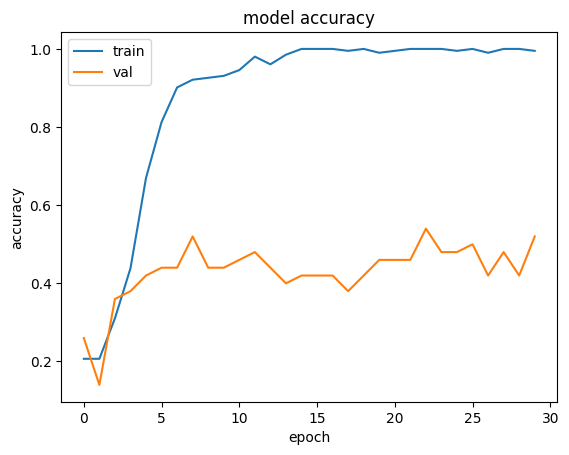

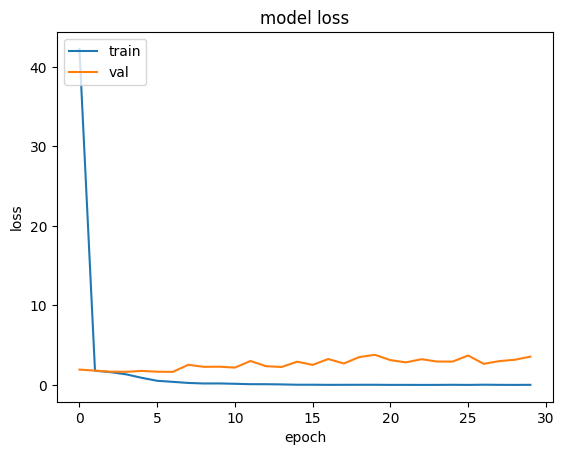

In [ ]:
plot_history(history)

#Data Augmentation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


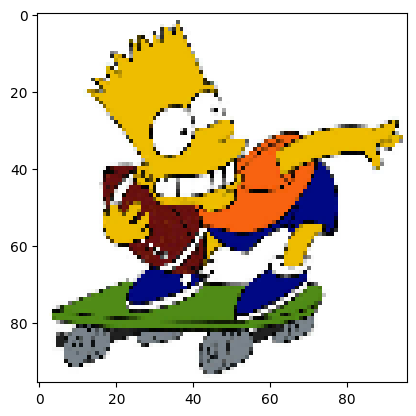

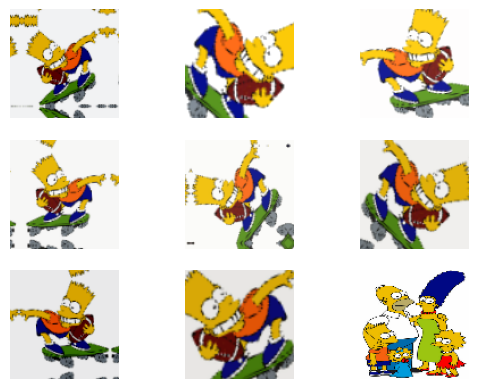

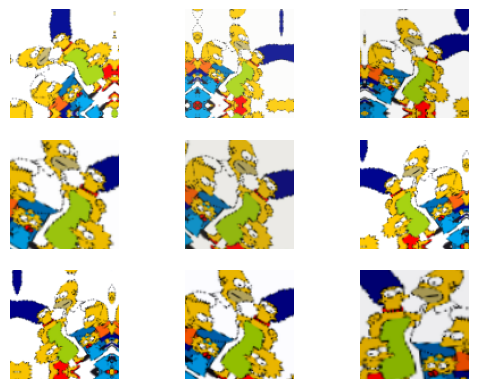

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(input_shape_[0],
                                  input_shape_[1],
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
  ]
)

for images, _ in train_ds.take(2):
  plt.imshow(images[7].numpy().astype("uint8"))
  plt.show()
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[7].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  data_augmentation, #Data Augmentation
  layers.Rescaling(1./255, input_shape=input_shape_),
  layers.Conv2D(32, 3, padding='same', activation='relu',input_shape=input_shape_),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.Dropout(0.1), #Regularization
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_ = 70
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - acc: 0.2227 - loss: 1.7792 - val_acc: 0.3400 - val_loss: 1.6470
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.3400 - loss: 1.6850 - val_acc: 0.3200 - val_loss: 1.5117
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.3683 - loss: 1.4974 - val_acc: 0.4800 - val_loss: 1.3004
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.5118 - loss: 1.2470 - val_acc: 0.4600 - val_loss: 1.2344
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc: 0.4638 - loss: 1.2681 - val_acc: 0.4600 - val_loss: 1.2002
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.5368 - loss: 1.0437 - val_acc: 0.4800 - val_loss: 1.1392
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.6658 - loss: 0.9988 - val_acc: 0.5600 - val_loss: 1.1142
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.5979 - loss: 0.9531 - val_acc: 0.5800 - val_loss: 1.0071
Epoch 9/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.5711 - loss: 1.0144 - 

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


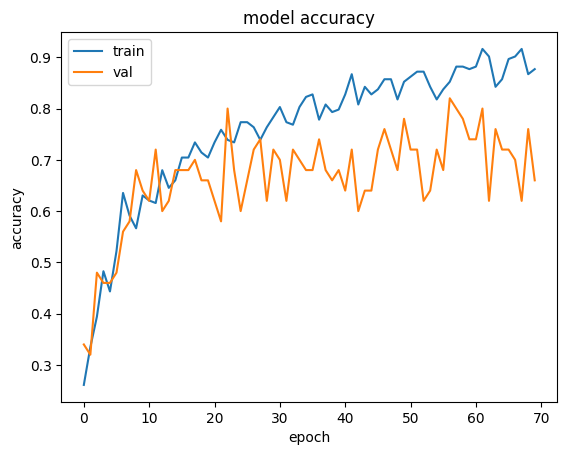

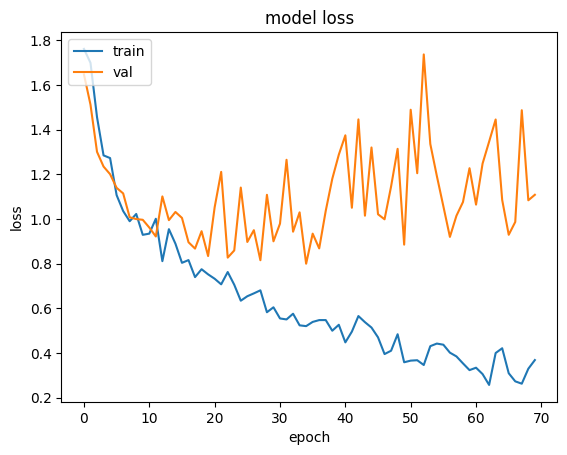

In [ ]:
plot_history(history)

#Transfer Learning

In [ ]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False


conv_layers.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 102, 102, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 24, 24, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 24, 24, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=input_shape_),
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=input_shape_),
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/my_model/model_checkpoint.weights.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    save_weights_only=True,
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 3, 3, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,145,926 (92.11 MB)

 Trainable params: 558,214 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - acc: 0.2807 - loss: 2.9618
Epoch 1: val_acc improved from -inf to 0.46000, saving model to /content/my_model/model_checkpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.2862 - loss: 2.9101 - val_acc: 0.4600 - val_loss: 1.1731
Epoch 2/20
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.5822 - loss: 1.0393
Epoch 2: val_acc improved from 0.46000 to 0.52000, saving model to /content/my_model/model_checkpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - acc: 0.5965 - loss: 0.9988 - val_acc: 0.5200 - val_loss: 1.2509
Epoch 3/20
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 0.7902 - loss: 0.6466
Epoch 3: val_acc improved from 0.52000 to 0.68000, saving model to /content/my_model/model_checkpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - acc: 0.7995 - loss: 0.6303 - val_acc: 0.6800 - val_loss: 1.0724
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.8637 - loss: 0.3949
Epoch 4: val_acc did not improve from 

In [ ]:
!ls -lah /content/my_model/model_checkpoint.weights.h5

-rw-r--r-- 1 root root 97M Oct 23 00:04 /content/my_model/model_checkpoint.weights.h5


In [ ]:
model.load_weights('/content/my_model/model_checkpoint.weights.h5')

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  f'./Simpsons/Teste/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 106 files belonging to 6 classes.


In [ ]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 883ms/step - acc: 0.5471 - loss: 1.8355


[1.6511551141738892, 0.5943396091461182]

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  f'./Simpsons/Teste/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

model.load_weights('/content/my_model/model_checkpoint.weights.h5')
model.evaluate(test_ds)

Found 106 files belonging to 6 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.5471 - loss: 1.8355


[1.6511551141738892, 0.5943396091461182]

#Transfer Leaning => Fine Tunning das ultimas 2 camadas de convolução!

In [ ]:
conv_layers.trainable=True

n_layers = len(conv_layers.layers)
print(n_layers)

for j in range(0,n_layers-10):
    conv_layers.layers[j].trainable = False



for j in range(n_layers-10,n_layers):
    conv_layers.layers[j].trainable = True


conv_layers.summary()
#base_model.layers[j].trainable = True

175


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 102, 102, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 24, 24, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 24, 24, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=input_shape_),

  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),
  #layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/my_model/model_checkpoint.weights.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    save_weights_only=True,
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 3, 3, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,145,926 (92.11 MB)

 Trainable params: 5,023,878 (19.16 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - acc: 0.2768 - loss: 2.2340
Epoch 1: val_acc improved from -inf to 0.46000, saving model to /content/my_model/model_checkpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.2859 - loss: 2.1996 - val_acc: 0.4600 - val_loss: 2.2802
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.8075 - loss: 0.5998
Epoch 2: val_acc improved from 0.46000 to 0.62000, saving model to /content/my_model/model_checkpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - acc: 0.8069 - loss: 0.6021 - val_acc: 0.6200 - val_loss: 2.2521
Epoch 3/20
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 0.9063 - loss: 0.3414
Epoch 3: val_acc did not improve from 0.62000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - acc: 0.9113 - loss: 0.3233 - val_acc: 0.5400 - val_loss: 5.8052
Epoch 4/20
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.9628 - loss: 0.1195
Epoch 4: val_acc did not improve from 0.62000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - acc: 0.9660 - loss: 

In [ ]:
np.set_printoptions(suppress=True)


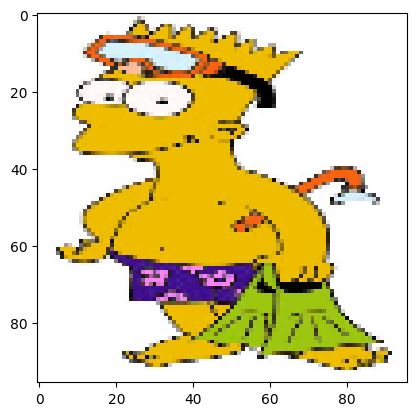

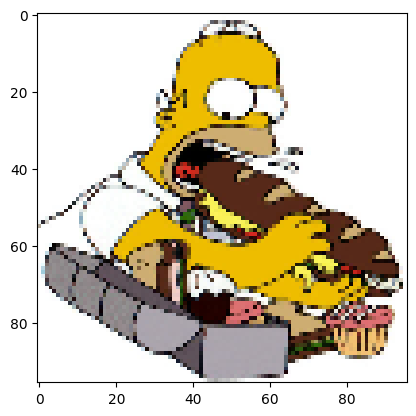

['bart' 'family' 'homer' 'lisa' 'maggie' 'marge']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.99999845 0.         0.00000118 0.00000039 0.00000003 0.        ]
 [0.023386   0.06058723 0.91548157 0.00052558 0.00000927 0.00001034]]
[0.99999845 0.         0.00000118 0.00000039 0.00000003 0.        ]
0
bart
[0.023386   0.06058723 0.91548157 0.00052558 0.00000927 0.00001034]
2
homer


In [ ]:
#Lendo uma imagem e avaliando com a rede

np.set_printoptions(suppress=True) #evita notacao scientifica
import cv2 #opencv library

imlist = []

img = cv2.imread('/content/Simpsons/Teste/bart/bart081.jpg')
img = cv2.resize(img,(96,96))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

imlist.append(img)


img = cv2.imread('/content/Simpsons/Teste/homer/homer069.jpg')
img = cv2.resize(img,(96,96))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imlist.append(img)

plt.imshow(img)
plt.show()

print(class_names)
res = model.predict(np.array(imlist))
print(res)

for r in res:
  print(r)
  class_id = np.argmax(r)
  print(class_id)
  print(class_names[class_id])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


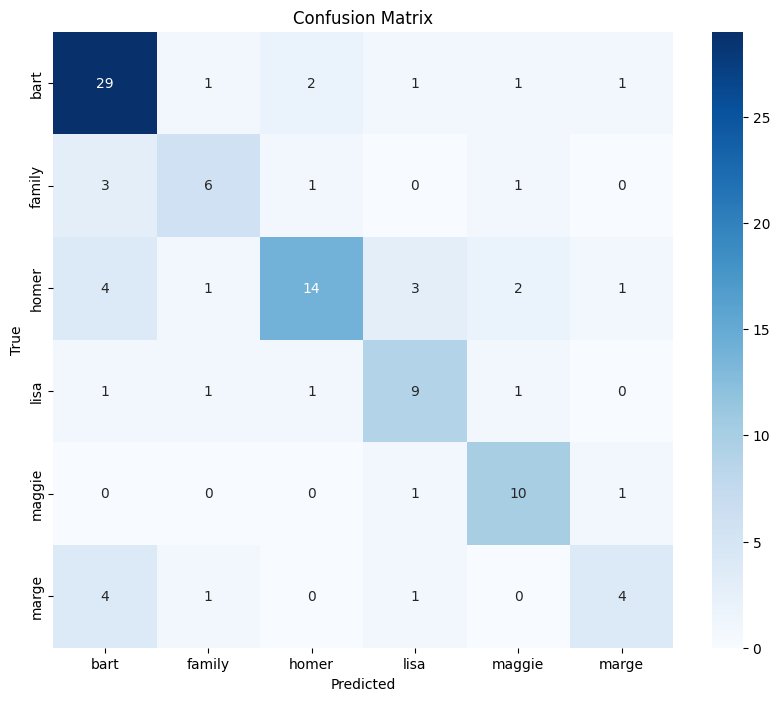

              precision    recall  f1-score   support

        bart       0.71      0.83      0.76        35
      family       0.60      0.55      0.57        11
       homer       0.78      0.56      0.65        25
        lisa       0.60      0.69      0.64        13
      maggie       0.67      0.83      0.74        12
       marge       0.57      0.40      0.47        10

    accuracy                           0.68       106
   macro avg       0.65      0.64      0.64       106
weighted avg       0.68      0.68      0.67       106



In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  y_true.extend(labels.numpy())
  y_pred.extend(predicted_labels)

cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


tf.Tensor([2 1 0 5 0 2 0 0 2 4 3 0 0 4 0 5 3 0 5 3 0 0 0 0 2 5 4 0 5 2 4 0], shape=(32,), dtype=int32)
(32, 96, 96, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


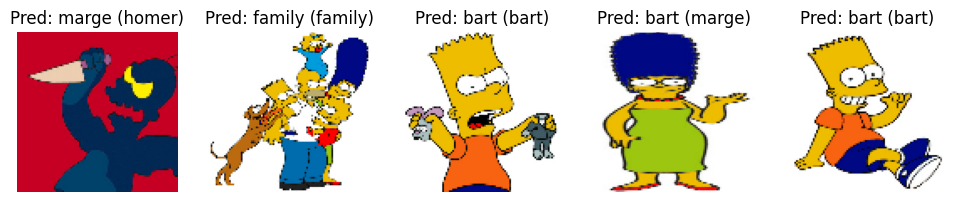

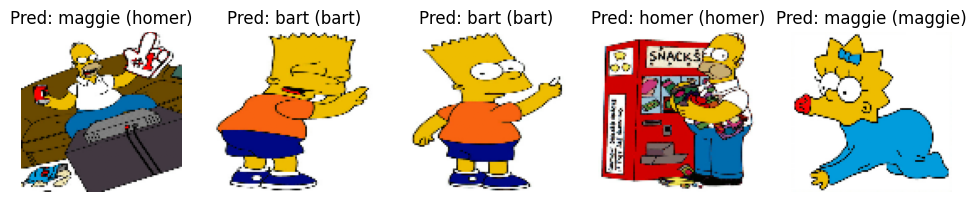

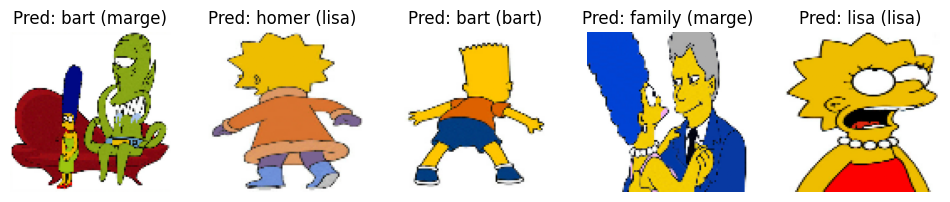

In [ ]:
import numpy as np
for img, lbl in test_ds.take(1):
  print(lbl)
  print(img.shape)
  prediction = model.predict(img)
  #print(prediction)
  predicted_labels = np.argmax(prediction, axis=1)
  titles = []
  for true,pred in zip(lbl,predicted_labels):
    titles.append(f'Pred: {class_names[pred]} ({class_names[true]})')

  plot_sidebyside(img[:5] / 255., titles[:5])
  plot_sidebyside(img[5:10] / 255., titles[5:10])
  plot_sidebyside(img[15:20] / 255., titles[15:20])